## Dataset: Carvana Image Masking Challenge

Download the Carvana dataset for image segmentation from Kaggle (https://www.kaggle.com/competitions/carvana-image-masking-challenge/overview).

In [ ]:
# Install Kaggle library
!pip install kaggle

# Create a new folder .kaggle and move kaggle.json into that
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Allocate permissions for this file
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#!kaggle competitions download -c carvana-image-masking-challenge
!kaggle competitions download -c carvana-image-masking-challenge

100% 24.4G/24.4G [03:01<00:00, 96.4MB/s]
100% 24.4G/24.4G [03:01<00:00, 144MB/s] 


In [ ]:
# Unzip train.zip and the corresponding masks.
!unzip -p carvana-image-masking-challenge.zip train.zip >train.zip
!unzip -p carvana-image-masking-challenge.zip train_masks.zip >train_masks.zip

# Unzip the zipped train files.
!unzip train.zip
!unzip train_masks.zip

## Setup

Import libraries and prepare the code.

In [ ]:
# Utilities
import os

# Algebra
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Neural Networks
import tensorflow as tf
from tensorflow import keras as ks

In [ ]:
def load_data_from_names(root_dir: str, fnames: list, shape=(256, 256)) -> np.array:
    # Given the root path and a list of file names as input, return the dataset 
    # array.
    images = []
    
    for idx, img_name in enumerate(fnames):
        x = Image.open(os.path.join(root_dir, img_name))
        x = x.resize(shape)
        x = np.array(x)
        images.append(x)

        if idx%100 == 99:
            print(f"Processed {idx+1} images.")
    return np.array(images)

# Load the names
image_names = os.listdir('./train')
mask_names = os.listdir('./train_masks')

image_names.sort()
mask_names.sort()

# To reduce the computational time, we consider only a subset of the dataset
N = 5000 # Number of total datapoints

image_names = image_names[:N]
mask_names = mask_names[:N]

# Create data. We will always use the notation that "x" is the input of the 
# network, "y" is the output.
x = load_data_from_names('./train', image_names)
y = load_data_from_names('./train_masks', mask_names)

# Print the dimension of the dataset.
print(f"The dimension of the dataset is: {x.shape}")

In [ ]:
# Split the training set into training and test.
TRAIN_SIZE = 4000

x_train = x[:TRAIN_SIZE]
y_train = y[:TRAIN_SIZE]

x_test = x[TRAIN_SIZE:]
y_test = y[TRAIN_SIZE:]

print(f"Train size: {x_train.shape}\nTest size: {x_test.shape}")

Train size: (4000, 256, 256, 3)
Test size: (1000, 256, 256, 3)


## Visualization

Visualize some image and the corresponding mask.

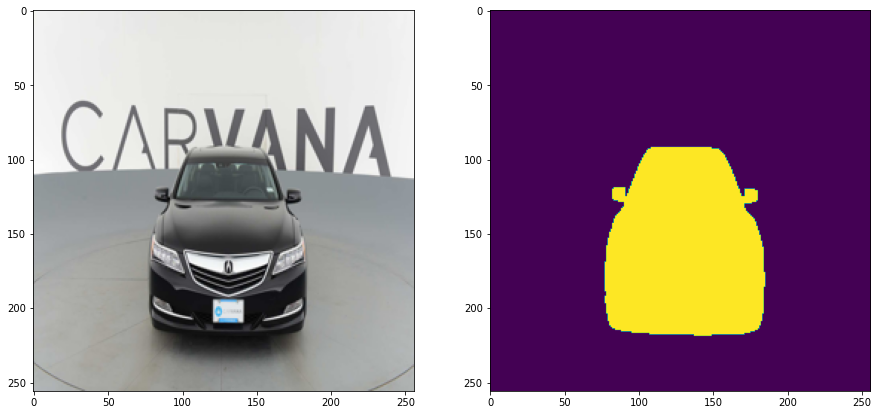

In [ ]:
def show(x, y, title=None):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(x)
    if title:
        plt.title(title[0])
    
    plt.subplot(1, 2, 2)
    plt.imshow(y)
    if title:
        plt.title(title[1])

    plt.show()

show(x_train[0], y_train[0])

## Model

Comparing results of different models:

*   CNN - trivial but not good
*   UNet - good enough
*   Unet++ - better implementation of UNet

For the comparison I will use **Accuracy**, **Intersention over Union** (IoU) and **Dice coefficient**.

## Accuracy
The accuracy is simply defined by considering the segmentation as a pixel-by-pixel classification. \\

## Intersection over Union
The Intersection over Union (IoU) is defined as the ratio between the intersection area between the predicted mask and the ground truth mask, over the union between the two masks. 

![](https://miro.medium.com/max/300/0*kraYHnYpoJOhaMzq.png)

Given that the mask is a binary image, it is trivial to compute both the intersection and the union (the latter, computed via the relationship:

$$
\mu (A \cup B) + \mu (A \cap B) = \mu (A) + \mu (B)
$$

where $\mu(A)$ is defined to be the Area of A. \\

Clearly, $IoU(y, y') \in [0, 1]$, and $IoU(y, y') = 1$ in the best case, where $y$ and $y'$ overlap perfectly, and $IoU(y, y') = 0$ when they don't overlap.

## Dice coefficient
The Dice coefficient is defined by twice the overlapping area of the two masks, over the sum of the area of the two masks.

![](https://miro.medium.com/max/429/1*yUd5ckecHjWZf6hGrdlwzA.png)

The implementation of the dice coefficient is similar to the implementation of the IoU, since both of them explicitely uses that a mask is between 0 and 1.

In [ ]:
from keras import backend as K
from keras.losses import binary_crossentropy

def iou_coeff(y_true, y_pred):
    smooth = 1

    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection

    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coeff(y_true, y_pred):
    smooth = 1

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# Function that evaluate the model on a dataset
def evaluate_model(model, x, y, fun):
    y_pred = model.predict(x) # Use the model to predict the output
    y = np.expand_dims(y, -1) # We need to add the channel dimension on y

    # Uniform the type of the array
    y_pred = y_pred.astype('float32')
    y = y.astype('float32')

    return fun(y, y_pred)

# Convolutional Neural Network (CNN)

In [ ]:
def build_cnn(input_shape, n_ch, L=3):
    x = ks.layers.Input(shape=input_shape)

    h = x
    for i in range(L):
        h = ks.layers.Conv2D(n_ch, kernel_size=3, padding='same')(h)
        h = ks.layers.ReLU()(h)

        n_ch = 2*n_ch
    
    y = ks.layers.Conv2D(1, kernel_size=1, activation='sigmoid')(h)
    return ks.models.Model(x, y)

CNN_model = build_cnn((256, 256, 3), 64, L=3)
CNN_model.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

print(CNN_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 re_lu (ReLU)                (None, 256, 256, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 128)     73856     
                                                                 
 re_lu_1 (ReLU)              (None, 256, 256, 128)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 256)     295168    
                                                                 
 re_lu_2 (ReLU)              (None, 256, 256, 256)     0     

In [ ]:
# Set hyperparameters
BATCH_SIZE = 32
N_EPOCHS = 20

# Training
hist = CNN_model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=N_EPOCHS,
              validation_split=0.1)

Epoch 1/20
113/113 [==============================] - 124s 1s/step - loss: 0.7050 - accuracy: 0.8444 - val_loss: 0.2811 - val_accuracy: 0.8923
Epoch 2/20
113/113 [==============================] - 125s 1s/step - loss: 0.3639 - accuracy: 0.8750 - val_loss: 0.2667 - val_accuracy: 0.9046
Epoch 3/20
113/113 [==============================] - 126s 1s/step - loss: 0.2695 - accuracy: 0.9010 - val_loss: 0.2736 - val_accuracy: 0.8976
Epoch 4/20
113/113 [==============================] - 126s 1s/step - loss: 0.2486 - accuracy: 0.9096 - val_loss: 0.2616 - val_accuracy: 0.9057
Epoch 5/20
113/113 [==============================] - 126s 1s/step - loss: 0.2408 - accuracy: 0.9141 - val_loss: 0.2186 - val_accuracy: 0.9242
Epoch 6/20
113/113 [==============================] - 126s 1s/step - loss: 0.2292 - accuracy: 0.9191 - val_loss: 0.2141 - val_accuracy: 0.9222
Epoch 7/20
113/113 [==============================] - 126s 1s/step - loss: 0.2379 - accuracy: 0.9172 - val_loss: 0.2182 - val_accuracy: 0.9220

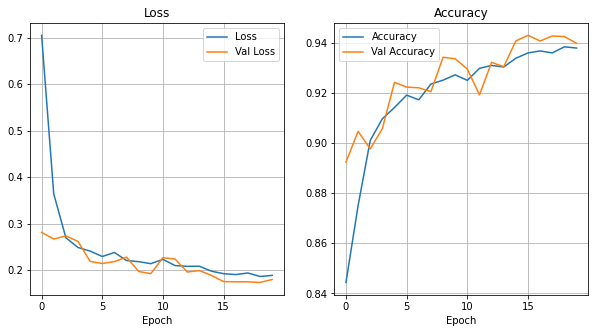

In [ ]:
# Check overfit
loss_history = hist.history['loss']
val_loss_history = hist.history['val_loss']

acc_history = hist.history['accuracy']
val_acc_history = hist.history['val_accuracy']

# Plot training history
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(acc_history)
plt.plot(val_acc_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'])
plt.title('Accuracy')
plt.show()

In [ ]:
# Evaluate IoU and Dice coefficient
iou = evaluate_model(CNN_model, x_test,  y_test, iou_coeff)
dice = evaluate_model(CNN_model, x_test,  y_test, dice_coeff)

print(f"The IoU of the trained model is {iou}, while its Dice coefficient is {dice}.")

The IoU of the trained model is 0.6289771199226379, while its Dice coefficient is 0.7709212303161621.


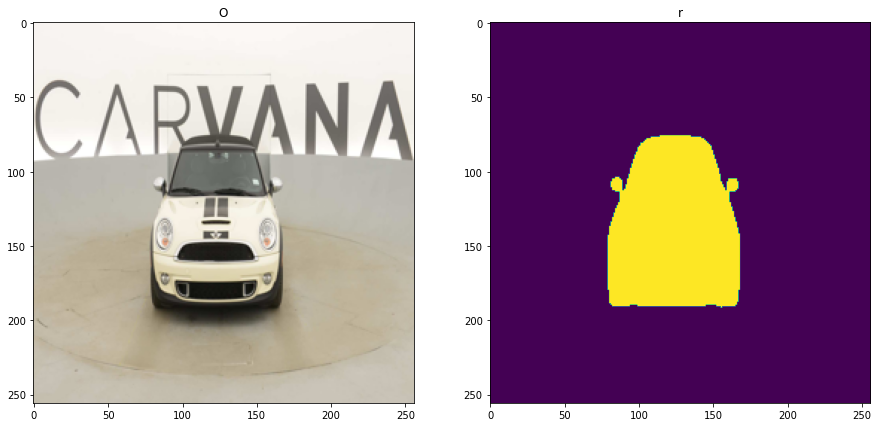

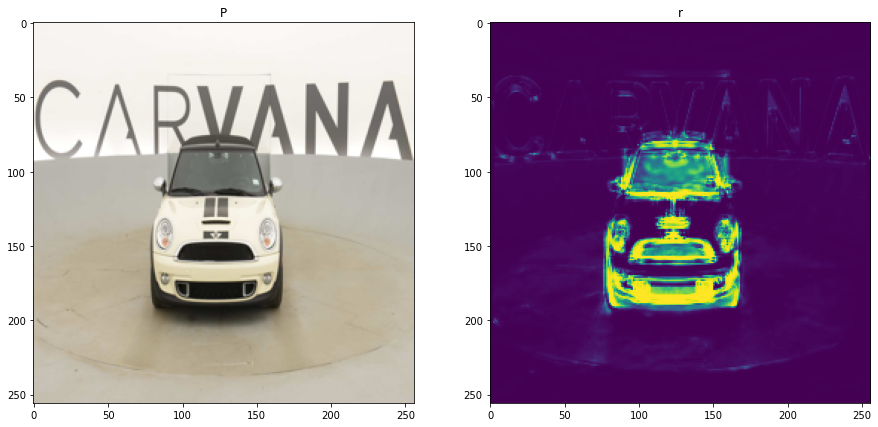

In [ ]:
# Qualitative results
y_pred = CNN_model.predict(x_test[:1])

show(x_test[0, :, :], y_test[0, :, :], title='Original')
show(x_test[0, :, :], y_pred[0, :, :, 0], title='Predicted')

# UNet

In [ ]:
def build_unet(input_shape, n_ch=32, L=4, conv_per_L=2):
    # Default parameters are the same of the diagram above, a part of the 
    # number of channels, which is set to 32.
    # L = number of floors
    # conv_per_L = number of convolutions every level.
    x = ks.layers.Input(shape=input_shape)

    # DOWN
    backup_layers = []
    h = x
    for l in range(L):

        # Each floor in the descent phase
        for c in range(conv_per_L):
            h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ks.layers.ReLU()(h)

        if l < L-1: # We don't want to downsample at the last level
            # Downsample
            backup_layers.append(h) # save for the skip connection 
            h = ks.layers.MaxPool2D(padding='same')(h)

            # Update the channels
            n_ch = n_ch * 2
    
    # UP (pay attention to do not double count the last level)
    for l in range(L-1):
        # Reduce the channels
        n_ch = n_ch // 2

        # Upsample
        h = ks.layers.Conv2DTranspose(n_ch, 3, 2, padding='same')(h)

        # Concatenate
        h = ks.layers.concatenate([h, backup_layers.pop(-1)])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ks.layers.ReLU()(h)
        
    # Output
    y = ks.layers.Conv2D(1, 1, activation='sigmoid')(h)
    return ks.models.Model(x, y)
    
unet_model = build_unet((256, 256, 3))
unet_model.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

print(unet_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu_3 (ReLU)                 (None, 256, 256, 32  0           ['conv2d_4[0][0]']               
                                )                                                           

In [ ]:
# Training
BATCH_SIZE = 32
N_EPOCHS = 20

hist = unet_model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=N_EPOCHS,
              validation_split=0.1)

Epoch 1/20
113/113 [==============================] - 83s 645ms/step - loss: 1.0713 - accuracy: 0.8158 - val_loss: 0.1733 - val_accuracy: 0.9303
Epoch 2/20
113/113 [==============================] - 68s 606ms/step - loss: 0.1094 - accuracy: 0.9578 - val_loss: 0.0654 - val_accuracy: 0.9746
Epoch 3/20
113/113 [==============================] - 69s 606ms/step - loss: 0.0610 - accuracy: 0.9770 - val_loss: 0.0459 - val_accuracy: 0.9824
Epoch 4/20
113/113 [==============================] - 69s 608ms/step - loss: 0.0391 - accuracy: 0.9851 - val_loss: 0.0294 - val_accuracy: 0.9886
Epoch 5/20
113/113 [==============================] - 69s 609ms/step - loss: 0.0303 - accuracy: 0.9885 - val_loss: 0.0267 - val_accuracy: 0.9896
Epoch 6/20
113/113 [==============================] - 69s 609ms/step - loss: 0.0256 - accuracy: 0.9902 - val_loss: 0.0222 - val_accuracy: 0.9914
Epoch 7/20
113/113 [==============================] - 69s 608ms/step - loss: 0.0231 - accuracy: 0.9912 - val_loss: 0.0200 - val_ac

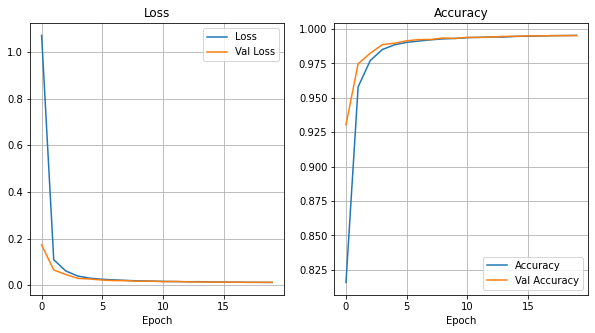

In [ ]:
# Check overfit
loss_history = hist.history['loss']
val_loss_history = hist.history['val_loss']

acc_history = hist.history['accuracy']
val_acc_history = hist.history['val_accuracy']

# Plot training history
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(acc_history)
plt.plot(val_acc_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'])
plt.title('Accuracy')
plt.show()

In [ ]:
unet_model.save_weights('segmentation_unet_train.h5')

In [ ]:
CNN_model.save_weights('segmentation_cnn_train.h5')

In [ ]:
# Evaluate IoU and Dice coeficient
iou = evaluate_model(unet_model, x_test,  y_test, iou_coeff)
dice = evaluate_model(unet_model, x_test,  y_test, dice_coeff)

print(f"The IoU of the trained model is {iou}, while its Dice coefficient is {dice}.")

The IoU of the trained model is 0.9668818116188049, while its Dice coefficient is 0.9830490350723267.


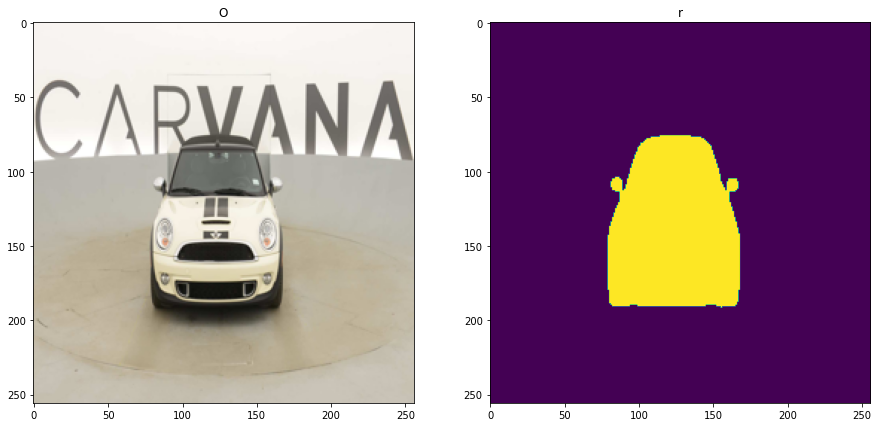

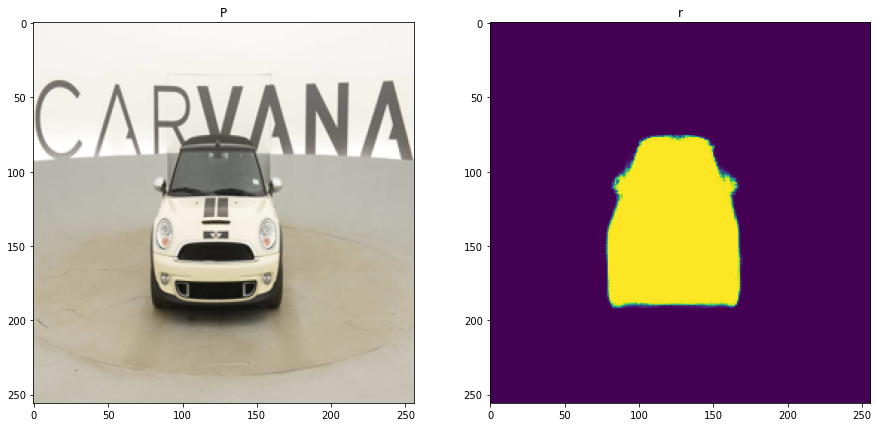

In [ ]:
# Qualitative results
y_pred = unet_model.predict(x_test[:1])

show(x_test[0, :, :], y_test[0, :, :], title='Original')
show(x_test[0, :, :], y_pred[0, :, :, 0], title='Predicted')

# UNet++

In [ ]:
def build_unetpp(input_shape, ch=64):
  # Get the input from the MAIN NET
  x = ks.layers.Input(input_shape)
  
  # BACKBONE - FIRST DIAGONAL
  x00 = ks.layers.Conv2D(ch, 3, padding="same", activation="relu")(x)
  d00 = ks.layers.Conv2D(ch, 3, 2, padding="same", activation="relu")(x00) # downsample
  #d00 = ks.layers.Dropout(0.1)(d00)

  x10 = ks.layers.Conv2D(2*ch, 3, padding="same", activation="relu")(d00)
  d10 = ks.layers.Conv2D(2*ch, 3, 2, padding="same", activation="relu")(x10) # downsample
  #d10 = ks.layers.Dropout(0.2)(d10)

  x20 = ks.layers.Conv2D(4*ch, 3, padding="same", activation="relu")(d10)
  d20 = ks.layers.Conv2D(4*ch, 3, 2, padding="same", activation="relu")(x20) # downsample
  #d20 = ks.layers.Dropout(0.3)(d20)

  x30 = ks.layers.Conv2D(8*ch, 3, padding="same", activation="relu")(d20)

  # SECOND DIAGONAL
  u10 = ks.layers.Conv2DTranspose(ch, 3, 2, padding="same", activation="relu")(x10) # upsample
  x01 = ks.layers.concatenate([x00, u10])
  #x01 = ks.layers.Dropout(0.1)(x01)
  x01 = ks.layers.Conv2D(ch, 3, padding="same", activation="relu")(x01)

  u20 = ks.layers.Conv2DTranspose(2*ch, 3, 2, padding="same", activation="relu")(x20) # upsample
  x11 = ks.layers.concatenate([x10, u20])
  #x11 = ks.layers.Dropout(0.2)(x11)
  x11 = ks.layers.Conv2D(2*ch, 3, padding="same", activation="relu")(x11)

  u30 = ks.layers.Conv2DTranspose(4*ch, 3, 2, padding="same", activation="relu")(x30) # upsample
  x21 = ks.layers.concatenate([x20, u30])
  #x21 = ks.layers.Dropout(0.3)(x21)
  x21 = ks.layers.Conv2D(4*ch, 3, padding="same", activation="relu")(x21)

  # THIRD DIAGONAL
  u11 = ks.layers.Conv2DTranspose(ch, 3, 2, padding="same", activation="relu")(x11) # upsample
  x02 = ks.layers.concatenate([x00, x01, u11])
  #x02 = ks.layers.Dropout(0.1)(x02)
  x02 = ks.layers.Conv2D(ch, 3, padding="same", activation="relu")(x02)

  u21 = ks.layers.Conv2DTranspose(2*ch, 3, 2, padding="same", activation="relu")(x21) # upsample
  x12 = ks.layers.concatenate([x10, x11, u21])
  #x12 = ks.layers.Dropout(0.2)(x12)
  x12 = ks.layers.Conv2D(2*ch, 3, padding="same", activation="relu")(x12)

  # LAST ELEMENT
  u12 = ks.layers.Conv2DTranspose(ch, 3, 2, padding="same", activation="relu")(x12)
  x03 = ks.layers.concatenate([x00, x01, x02, u12])
  #x03 = ks.layers.Dropout(0.1)(x03)
  x03 = ks.layers.Conv2D(ch, 3, padding="same", activation="relu")(x03)

  out = ks.layers.average([x01, x02, x03])
  out = ks.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(out)

  #out1 = ks.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(x01)
  #out2 = ks.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(x02)
  #out3 = ks.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(x03)
  return ks.Model(x, out)

unetpp_model = build_unetpp((256, 256, 3), 32)
unetpp_model.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

print(unetpp_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_44 (Conv2D)             (None, 256, 256, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_44[0][0]']              
                                )                                                           

In [ ]:
# Training
BATCH_SIZE = 32
N_EPOCHS = 20

hist = unetpp_model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=N_EPOCHS,
              validation_split=0.1)

Epoch 1/20
113/113 [==============================] - 117s 1s/step - loss: 0.4327 - accuracy: 0.8650 - val_loss: 0.1849 - val_accuracy: 0.9280
Epoch 2/20
113/113 [==============================] - 117s 1s/step - loss: 0.1348 - accuracy: 0.9492 - val_loss: 0.1049 - val_accuracy: 0.9614
Epoch 3/20
113/113 [==============================] - 118s 1s/step - loss: 0.0956 - accuracy: 0.9653 - val_loss: 0.0616 - val_accuracy: 0.9764
Epoch 4/20
113/113 [==============================] - 118s 1s/step - loss: 0.0603 - accuracy: 0.9772 - val_loss: 0.0440 - val_accuracy: 0.9829
Epoch 5/20
113/113 [==============================] - 118s 1s/step - loss: 0.0454 - accuracy: 0.9829 - val_loss: 0.0363 - val_accuracy: 0.9861
Epoch 6/20
113/113 [==============================] - 118s 1s/step - loss: 0.0401 - accuracy: 0.9849 - val_loss: 0.0324 - val_accuracy: 0.9875
Epoch 7/20
113/113 [==============================] - 119s 1s/step - loss: 0.0325 - accuracy: 0.9878 - val_loss: 0.0276 - val_accuracy: 0.9895

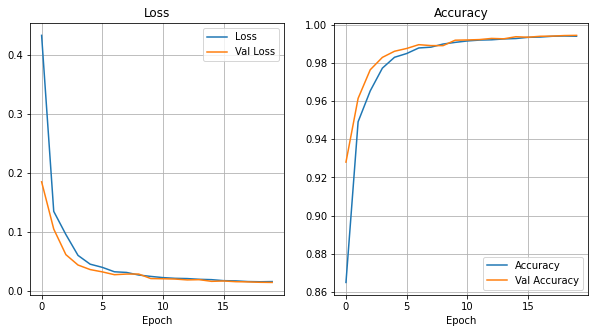

In [ ]:
# Check overfit
loss_history = hist.history['loss']
val_loss_history = hist.history['val_loss']

acc_history = hist.history['accuracy']
val_acc_history = hist.history['val_accuracy']

# Plot training history
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(acc_history)
plt.plot(val_acc_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'])
plt.title('Accuracy')
plt.show()

In [ ]:
# Evaluate IoU and Dice coeficient
iou = evaluate_model(unetpp_model, x_test,  y_test, iou_coeff)
dice = evaluate_model(unetpp_model, x_test,  y_test, dice_coeff)

print(f"The IoU of the trained model is {iou}, while its Dice coefficient is {dice}.")

The IoU of the trained model is 0.9591568112373352, while its Dice coefficient is 0.9790744185447693.


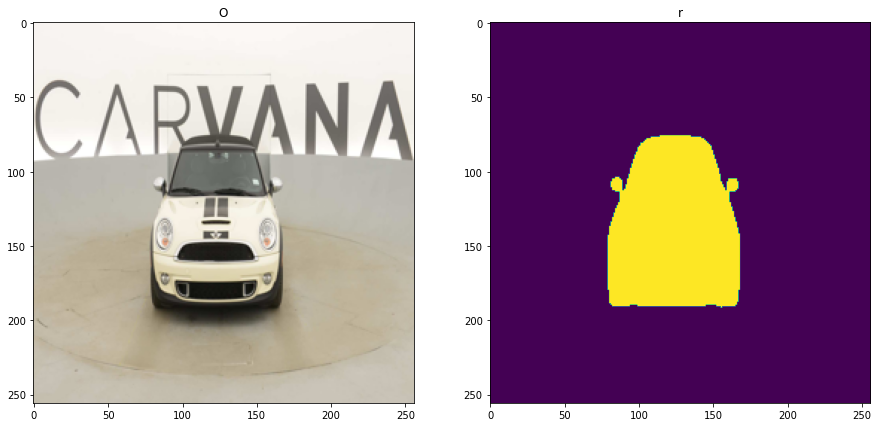

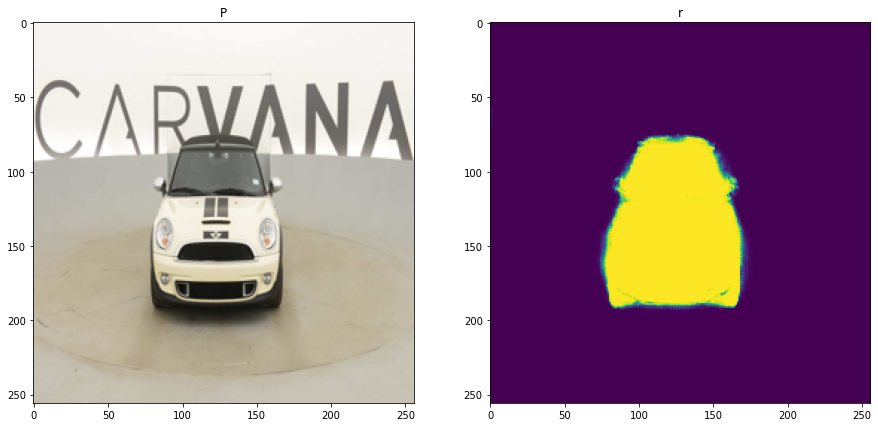

In [ ]:
# Qualitative results
y_pred = unetpp_model.predict(x_test[:1])

show(x_test[0, :, :], y_test[0, :, :], title='Original')
show(x_test[0, :, :], y_pred[0, :, :, 0], title='Predicted')